# USGS Gage Data Extraction (Stage and Flow) 

## Imports

In [8]:
from dataretrieval import nwis, codes
import requests
import contextily as ctx
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import hydrofunctions as hf
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import spatialpandas as sp
# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Fetch Active USGS Sites for Louisiana

In [9]:
def fetch_usgs_data_for_louisiana():
    """
    Fetches data for active USGS sites in Louisiana from the USGS NWIS service.

    This function retrieves site data in 'rdb' format, focusing on sites within the state of Louisiana that are currently active.
    The returned data includes the site number, site name, latitude, and longitude for each site.

    Returns:
        list of tuple: A list of tuples, where each tuple contains four elements:
            - site_number (str): The site's unique identifier.
            - site_name (str): The name of the site.
            - latitude (str): The latitude of the site.
            - longitude (str): The longitude of the site.

    Note:
        If there's an issue fetching the data, the function prints an error message and returns None.
    """
    BASE_URL = "https://waterservices.usgs.gov/nwis/site/"
    PARAMS = {
        "format": "rdb",
        "stateCd": "LA",
        "siteStatus": "active"
    }

    response = requests.get(BASE_URL, params=PARAMS)

    if response.status_code != 200:
        print("Error fetching data from USGS.")
        return

    lines = response.text.split("\n")
    sites = []

    for line in lines:
        if not line.startswith("#") and line:  # ignore comments and empty lines
            data = line.split("\t")
            if len(data) > 5:  # ensure there's enough data to unpack
                site_number, site_name, latitude, longitude = data[1], data[2], data[4], data[5]
                sites.append((site_number, site_name, latitude, longitude))

    return sites

## Process and Convert USGS Site Data to GeoDataFrame

In [10]:
"""
Processes the fetched USGS site data for Louisiana, extracts longitudes and latitudes, and converts them to a GeoDataFrame.

The script carries out the following steps:
1. Fetch USGS site data for Louisiana.
2. Extract longitude and latitude values from the site data.
3. Convert longitude and latitude string values to numeric format. Invalid parsing results in NaN values.
4. Filters out sites without valid numerical latitude and longitude values.
5. Converts the valid sites' data into a GeoDataFrame with corresponding geometries.
6. Sets the initial Coordinate Reference System (CRS) to WGS84 (EPSG:4326) and then reprojects the data to NAD27 (EPSG:4267).

Attributes:
    sites (list of tuple): Fetched USGS site data.
    longitudes (list of str): Extracted longitudes from the site data.
    latitudes (list of str): Extracted latitudes from the site data.
    longitudes_numeric (Series): Longitudes converted to numeric format.
    latitudes_numeric (Series): Latitudes converted to numeric format.
    valid_sites (list of tuple): Filtered sites having valid numerical latitude and longitude values.
    geometry (list of Point): List of Point geometries corresponding to each valid site.
    gdf (GeoDataFrame): GeoDataFrame constructed from valid sites.
    gdf_nad27 (GeoDataFrame): GeoDataFrame reprojected to NAD27 (EPSG:4267) CRS.
"""
sites = fetch_usgs_data_for_louisiana()

# Extract the longitude and latitude values
longitudes = [site[3] for site in sites]
latitudes = [site[2] for site in sites]

# Convert string values to numeric, setting errors='coerce' to turn invalid parsing into NaN
longitudes_numeric = pd.to_numeric(longitudes, errors='coerce')
latitudes_numeric = pd.to_numeric(latitudes, errors='coerce')

# Filter out any sites that don't have valid numerical latitude and longitude
valid_sites = [sites[i] for i in range(len(sites)) if not (pd.isna(longitudes_numeric[i]) or pd.isna(latitudes_numeric[i]))]

# Convert valid sites data to GeoDataFrame
geometry = [Point(xy) for xy in zip(pd.to_numeric([site[3] for site in valid_sites]), pd.to_numeric([site[2] for site in valid_sites]))]
gdf = gpd.GeoDataFrame(valid_sites, columns=['Site Number', 'Site Name', 'Latitude', 'Longitude'], geometry=geometry)

# Set the initial CRS to WGS84 (EPSG:4326) and then reproject to NAD27 (EPSG:4267)
gdf.crs = "EPSG:4326"
gdf_nad27 = gdf.to_crs("EPSG:4267")


## Reprojected USGS Site Data in Louisiana with Basemap Background

In [11]:
"""
Visualizes the USGS site data (reprojected to NAD27) on a map with a basemap background.

The script carries out the following steps:
1. Plots the `gdf_nad27` GeoDataFrame, which contains the reprojected USGS site data.
2. Adds a basemap in the background using the `contextily` library.
3. Displays the map with the USGS site data points.

Attributes:
    gdf_nad27 (GeoDataFrame): GeoDataFrame containing the USGS site data reprojected to NAD27 (EPSG:4267) CRS.

Note:
    Ensure that the `geopandas`, `matplotlib`, and `contextily` libraries are imported, and that `gdf_nad27` is already defined and populated before executing the script.
"""


# Plot the USGS site data
ax = gdf_nad27.to_crs(epsg=3857).plot(figsize=(10, 10), markersize=5, color='red', alpha=0.7)

# Add a basemap in the background
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Set map title and axis labels
ax.set_title('USGS Site Data in Louisiana')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off()

plt.tight_layout()
plt.show()

C:\Users\asaharia\AppData\Local\Temp\ipykernel_17216\4113536060.py:30: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Save the GeoDataFrame to a Shapefile

In [12]:
"""
Saves the reprojected USGS gage data for Louisiana to a shapefile.

The script defines the output path for the shapefile and then saves the GeoDataFrame, which is in the NAD27 (EPSG:4267) CRS, to that path.

Attributes:
    output_path (str): The path where the shapefile will be saved.
    gdf_nad27 (GeoDataFrame): The GeoDataFrame containing reprojected USGS gage data for Louisiana.

Note:
    Ensure the `geopandas` library is imported and that `gdf_nad27` is already defined and populated before executing the script.
"""
output_path = "usgs_gages_louisiana_nad27.shp"
gdf_nad27.to_file(output_path)


C:\Users\asaharia\AppData\Local\Temp\ipykernel_17216\1972694124.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nad27.to_file(output_path)


## Export GeoDataFrame to a CSV File

In [13]:
"""
Exports the reprojected USGS gage data for Louisiana to a CSV file, excluding the geometry column.

The script defines the output path for the CSV file and then saves the GeoDataFrame, after dropping its geometry column, to that path.

Attributes:
    csv_output_path (str): The path where the CSV file will be saved.
    gdf_nad27 (GeoDataFrame): The GeoDataFrame containing reprojected USGS gage data for Louisiana.
"""
#  save the data to a CSV file
csv_output_path = "usgs_gages_louisiana.csv"
gdf_nad27.drop(columns='geometry').to_csv(csv_output_path, index=False)

## Read and Reproject HUC8 Shapefile, and Clip Gages to HUC8 Boundary

In [14]:
"""
Loads a HUC8 boundary shapefile, reprojects it to match the CRS of the USGS gages, and then clips the gages to the HUC8 boundary.

The script carries out the following steps:
1. Defines the path to the HUC8 boundary shapefile.
2. Imports necessary geospatial libraries.
3. Reads the HUC8 boundary shapefile into a GeoDataFrame.
4. Reprojects the HUC8 boundary to match the CRS of the USGS gages (NAD27).
5. Uses the `clip` function to clip the gages data to the reprojected HUC8 boundary.

Attributes:
    huc8_path (str): The path to the HUC8 boundary shapefile.
    huc8_gdf (GeoDataFrame): GeoDataFrame containing the HUC8 boundary data.
    huc8_gdf_reprojected (GeoDataFrame): The HUC8 boundary data reprojected to NAD27 (EPSG:4267) CRS.
    clipped_gages (GeoDataFrame): The USGS gages data clipped to the HUC8 boundary.
"""
# Define the path to your HUC8 shapefile
huc8_path = "Z:\LWI2023-24\HUC8s_roughcut.shp"  # Replace with the actual path to your HUC8 shapefile

# Ensure that the 'gdf_nad27' variable, which is used to represent the gages data, is defined and available.

# Read the HUC8s shapefile using geopandas
import geopandas as gpd

huc8_gdf = gpd.read_file(huc8_path)

# Reproject the HUC8s shapefile to match the CRS of the gages (NAD27)
huc8_gdf_reprojected = huc8_gdf.to_crs(gdf_nad27.crs)

# Use geopandas' clip function to clip the gages to the reprojected HUC8s boundary
clipped_gages = gpd.clip(gdf_nad27, huc8_gdf_reprojected)


## Clipped USGS Site Data Visualization with HUC8 Boundary Background

In [15]:
"""
Visualizes the clipped USGS gages data on a static map, overlaying the HUC8 boundary.

The script carries out the following steps:
1. Initializes a plotting figure with specified dimensions.
2. Plots the reprojected HUC8 boundary on the figure as a background layer.
3. Overlays the clipped USGS gages data on top of the HUC8 boundary.
4. Sets the map title, x-axis and y-axis labels, and a legend indicating the respective data layers.
5. Displays the resulting map.

Attributes:
    huc8_gdf_reprojected (GeoDataFrame): GeoDataFrame containing the HUC8 boundary data reprojected to NAD27 (EPSG:4267) CRS.
    clipped_gages (GeoDataFrame): GeoDataFrame containing the USGS gages data clipped to the HUC8 boundary.

Note:
    Ensure that the `matplotlib` and `geopandas` libraries are imported, and that both `huc8_gdf_reprojected` and `clipped_gages` are defined and populated before executing the script.
"""
# Initialize a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the HUC8 boundary as the background
huc8_gdf_reprojected.plot(ax=ax, color='lightgray', edgecolor='black', label='HUC8 Boundary')

# Plot the clipped USGS site data on top
clipped_gages.plot(ax=ax, markersize=50, color='red', alpha=0.7, label='USGS Gages')

# Set map title, legend, and axis labels
ax.set_title('Clipped USGS Site Data with HUC8 Boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

C:\Users\asaharia\AppData\Local\Temp\ipykernel_17216\3422191915.py:34: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Save Clipped USGS Gages to a Shapefile

In [16]:
"""
Saves the clipped USGS gages data for Louisiana to a shapefile.

The script defines the output path for the shapefile and then saves the clipped GeoDataFrame, which contains USGS gages data clipped to the HUC8 boundary, to that path.

Attributes:
    clipped_output_path (str): The path where the clipped shapefile will be saved.
    clipped_gages (GeoDataFrame): The GeoDataFrame containing USGS gages data that has been clipped to the HUC8 boundary.
"""
clipped_output_path = "clipped_usgs_gages_louisiana.shp"
clipped_gages.to_file(clipped_output_path)

C:\Users\asaharia\AppData\Local\Temp\ipykernel_17216\2972869898.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_gages.to_file(clipped_output_path)


## Export Clipped USGS Gages Data to a CSV File

In [17]:
"""
Exports the clipped USGS gages data for Louisiana to a CSV file, excluding the geometry column.

The script defines the output path for the CSV file and then saves the clipped GeoDataFrame, after dropping its geometry column, to that path.

Attributes:
    clipped_csv_output_path (str): The path where the CSV file will be saved.
    clipped_gages (GeoDataFrame): The GeoDataFrame containing USGS gages data that has been clipped to the HUC8 boundary.
"""
# Drop the geometry column and save the Clipped gage data to a CSV file
clipped_csv_output_path = "clipped_usgs_gages_louisiana.csv"
clipped_gages.drop(columns='geometry').to_csv(clipped_csv_output_path, index=False)


## Fetch and Process Stage and Discharge Data for Clipped USGS Gages

In [18]:
"""
Fetches stage and discharge data for a list of USGS gages within a specified date range and processes the retrieved data.

The script carries out the following steps:
1. Defines the start and end dates for data retrieval.
2. Extracts the site numbers from the previously defined clipped gages data.
3. Initializes lists to store stage and discharge data for each site.
4. Iterates over each site and fetches data using the `nwis` service.
5. Processes the fetched data, applies datum corrections if available, and extracts stage and discharge data.
6. Concatenates the stage and discharge data for all sites into two separate DataFrames.

Attributes:
    START_DATE (str): The start date for data retrieval in the format 'YYYY-MM-DD'.
    END_DATE (str): The end date for data retrieval in the format 'YYYY-MM-DD'.
    site_list (list of str): List of site numbers extracted from the clipped gages data.
    datum_corr_list (list of float): List of datum corrections for each site. Initialized with zeros if not previously defined.
    stage_dfs (list of DataFrame): List to store individual DataFrames containing stage data for each site.
    discharge_dfs (list of DataFrame): List to store individual DataFrames containing discharge data for each site.
    df_usgs_stage (DataFrame): Consolidated DataFrame containing stage data for all sites.
    df_usgs_discharge (DataFrame): Consolidated DataFrame containing discharge data for all sites.

Note:
    Ensure the `pandas` library and `nwis` from `dataretrieval` are imported, and that `clipped_gages` is already defined and populated before executing the script.
"""
# Define the date range
START_DATE = "2014-11-05"
END_DATE = "2022-12-11"

# Extract site numbers from clipped_gages
site_list = clipped_gages["Site Number"].tolist()

# Initialize datum_corr_list with zeros if not defined
datum_corr_list = [0] * len(site_list)

# Initialize lists to store DataFrames for stage and discharge data
stage_dfs = []
discharge_dfs = []

# Fetch the data for each site
for site in site_list:
    site_name = f"{site}, USGS"  # Assuming all sites are from USGS for naming
    try:
        # Use nwis to fetch the data
        data = nwis.get_record(sites=site, service='iv', start=START_DATE, end=END_DATE)
        data.index = pd.to_datetime(data.index, utc=True).tz_convert(tz="America/Chicago")
        data = data.groupby(by=pd.Grouper(freq='D')).mean(numeric_only=True)
        
        # Check if datum correction is available for the site, else default to 0
        datum_corr = datum_corr_list[site_list.index(site)]
        
        # Extract stage and discharge data and store in the list
        if '00065' in data.columns:  # Stage data
            stage_dfs.append(data[['00065']].rename(columns={'00065': site_name}) + datum_corr)
        if '00060' in data.columns:  # Discharge data
            discharge_dfs.append(data[['00060']].rename(columns={'00060': site_name}))
            
    except Exception as e:
        print(f"Error encountered for site {site_name}: {e}")

# Concatenate all DataFrames in the list
df_usgs_stage = pd.concat(stage_dfs, axis=1)
df_usgs_discharge = pd.concat(discharge_dfs, axis=1)

ValueError: No objects to concatenate

## Examine and Display Stage and Discharge Data Summary

In [118]:
"""
Examines and displays a summary of the fetched stage and discharge data for USGS gages.

The script carries out the following steps:
1. Checks if the `df_usgs_stage` DataFrame is empty. If not, it prints the first few rows, data information, and statistical summary of the stage data.
2. Checks if the `df_usgs_discharge` DataFrame is empty. If not, it prints the first few rows, data information, and statistical summary of the discharge data.

Attributes:
    df_usgs_stage (DataFrame): DataFrame containing consolidated stage data for USGS gages.
    df_usgs_discharge (DataFrame): DataFrame containing consolidated discharge data for USGS gages.

Note:
    Ensure that the `pandas` library is imported, and that `df_usgs_stage` and `df_usgs_discharge` are already defined and populated before executing the script.
"""
# Examine the fetched data
# Examine stage data
if not df_usgs_stage.empty:
    print("Stage Data:")
    print(df_usgs_stage.head())
    print("\nStage Data Info:")
    print(df_usgs_stage.info())
    print("\nStage Data Statistics:")
    print(df_usgs_stage.describe())
else:
    print("No stage data available.")
# Examine discharge data
if not df_usgs_discharge.empty:
    print("\nDischarge Data:")
    print(df_usgs_discharge.head())
    print("\nDischarge Data Info:")
    print(df_usgs_discharge.info())
    print("\nDischarge Data Statistics:")
    print(df_usgs_discharge.describe())
else:
    print("\nNo discharge data available.")


Stage Data:
                           07380249, USGS  07380245, USGS  073802516, USGS  \
datetime                                                                     
2014-11-05 00:00:00-06:00             NaN             NaN         7.332813   
2014-11-06 00:00:00-06:00             NaN             NaN         7.207187   
2014-11-07 00:00:00-06:00             NaN             NaN         7.186458   
2014-11-08 00:00:00-06:00             NaN             NaN         7.230625   
2014-11-09 00:00:00-06:00             NaN             NaN         7.209167   

                           07380260, USGS  291929089562600, USGS  \
datetime                                                           
2014-11-05 00:00:00-06:00             NaN               3.184167   
2014-11-06 00:00:00-06:00             NaN               3.016250   
2014-11-07 00:00:00-06:00             NaN               2.905000   
2014-11-08 00:00:00-06:00             NaN               2.999167   
2014-11-09 00:00:00-06:00        

## Export Stage and Discharge Statistics to CSV

In [119]:
"""
Exports the statistical summaries of stage and discharge data to separate CSV files.

The script carries out the following steps:
1. Checks if the `df_usgs_stage` DataFrame is empty. If not, calculates its statistical summary and exports it to `stage_data_statistics.csv`.
2. Checks if the `df_usgs_discharge` DataFrame is empty. If not, calculates its statistical summary and exports it to `discharge_data_statistics.csv`.

Attributes:
    df_usgs_stage (DataFrame): DataFrame containing consolidated stage data for USGS gages.
    df_usgs_discharge (DataFrame): DataFrame containing consolidated discharge data for USGS gages.
    stage_statistics (DataFrame): Statistical summary of `df_usgs_stage`.
    discharge_statistics (DataFrame): Statistical summary of `df_usgs_discharge`.

Note:
    Ensure that the `pandas` library is imported, and that `df_usgs_stage` and `df_usgs_discharge` are already defined and populated before executing the script.
"""
# Export stage statistics to CSV if data is available
if not df_usgs_stage.empty:
    stage_statistics = df_usgs_stage.describe()
    stage_statistics.to_csv("stage_data_statistics.csv")

# Export discharge statistics to CSV if data is available
if not df_usgs_discharge.empty:
    discharge_statistics = df_usgs_discharge.describe()
    discharge_statistics.to_csv("discharge_data_statistics.csv")

## Visualizing USGS Gages Based on Mean Stage Data

In [120]:
"""
Creates an interactive map displaying USGS gages with their average stage values, omitting gages with NaN mean_stage values.

The function does the following:
1. Calculates the center of the data to initialize the map's view.
2. Creates an interactive map object using `folium`.
3. Iterates over each gage from the `clipped_gages` DataFrame.
4. Skips gages with NaN `mean_stage` values.
5. Assigns a color to each gage based on its `capped_stage` value.
6. Plots each gage as a circle marker on the map with a popup displaying the site number and average stage.
7. Displays the interactive map.

Attributes:
    latitude_center (float): The mean latitude of all gages.
    longitude_center (float): The mean longitude of all gages.
    m (folium.Map): The interactive map object.

Note:
    Ensure the `folium`, `matplotlib.colors` (as `mcolors`), and `pandas` (as `pd`) libraries are imported, and that `clipped_gages`, `norm`, and other necessary variables are already defined and populated before executing the script.
"""
# Calculate the center of your data for initializing the map view:
latitude_center = clipped_gages.geometry.y.mean()
longitude_center = clipped_gages.geometry.x.mean()

# Create a map object:
m = folium.Map(location=[latitude_center, longitude_center], zoom_start=7)

# Plot each point from the DataFrame to the map, skipping those with NaN mean_stage values:
for _, row in clipped_gages.iterrows():
    if not pd.isna(row['mean_stage']):
        # Assign color based on capped_stage value:
        color = plt.cm.viridis(norm(row['capped_stage']))
        color = mcolors.to_hex(color)

        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=5,
            popup=f"Site: {row['Site Number']}, Avg Stage: {row['mean_stage']:.2f}",
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)

# Display the map:
m

KeyError: 'mean_stage'

## Interactive Map of USGS Gages by Average Discharge

In [121]:
"""
Creates an interactive map displaying USGS gages with their average discharge values, omitting gages with NaN mean_discharge values.

The function does the following:
1. Calculates the center of the data to initialize the map's view.
2. Creates an interactive map object using `folium`.
3. Drops gages with NaN `mean_discharge` values from the `clipped_gages` DataFrame.
4. Iterates over each gage from the `clipped_gages` DataFrame.
5. Assigns a color to each gage based on its `mean_discharge` value.
6. Plots each gage as a circle marker on the map with a popup displaying the site number and average discharge.
7. Displays the interactive map.

Attributes:
    latitude_center (float): The mean latitude of all gages.
    longitude_center (float): The mean longitude of all gages.
    m (folium.Map): The interactive map object.

Note:
    Ensure the `folium`, `matplotlib.colors` (as `mcolors`), and `pandas` (as `pd`) libraries are imported, and that `clipped_gages`, and other necessary variables are already defined and populated before executing the script.
"""

# Calculate the center of your data for initializing the map view:
latitude_center = clipped_gages.geometry.y.mean()
longitude_center = clipped_gages.geometry.x.mean()

# Create a map object:
m = folium.Map(location=[latitude_center, longitude_center], zoom_start=7)

# Add the average discharge data to the clipped_gages dataframe
def get_mean_discharge(site):
    key = f"{site}, USGS"
    return df_usgs_discharge[key].mean() if key in df_usgs_discharge.columns else np.nan

clipped_gages['mean_discharge'] = clipped_gages['Site Number'].apply(get_mean_discharge)

# Drop rows with NaN mean_discharge values
clipped_gages = clipped_gages.dropna(subset=['mean_discharge'])

# Set the colormap normalization based on the range of mean_discharge values
norm = mcolors.Normalize(vmin=clipped_gages['mean_discharge'].min(), vmax=clipped_gages['mean_discharge'].max())

# Plot each point from the DataFrame to the map:
for _, row in clipped_gages.iterrows():
    # Assign color based on mean_discharge value:
    color = plt.cm.viridis(norm(row['mean_discharge']))
    color = mcolors.to_hex(color)

    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],
        radius=5,
        popup=f"Site: {row['Site Number']}, Avg Discharge: {row['mean_discharge']:.2f} ft³/s",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)

# Display the map:
m

C:\Users\asaharia\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Export Stage and Discharge Data to CSV Files

In [122]:
"""
Exports the stage and discharge data for USGS gages to separate CSV files.

The script carries out the following steps:
1. Saves the `df_usgs_stage` DataFrame to a CSV file named "stage_data.csv".
2. Saves the `df_usgs_discharge` DataFrame to a CSV file named "discharge_data.csv".

Attributes:
    df_usgs_stage (DataFrame): DataFrame containing consolidated stage data for USGS gages.
    df_usgs_discharge (DataFrame): DataFrame containing consolidated discharge data for USGS gages.
"""
# Save the DataFrames to CSV files
df_usgs_stage.to_csv("stage_data.csv")
df_usgs_discharge.to_csv("discharge_data.csv")

## Display Column Names of the Stage Data DataFrame

In [123]:
"""
Displays the column names of the `df_usgs_stage` DataFrame, which contains consolidated stage data for USGS gages.

The script prints the column names of the `df_usgs_stage` DataFrame to provide a quick overview of the available data columns.

Attributes:
    df_usgs_stage (DataFrame): DataFrame containing consolidated stage data for USGS gages.
"""
print(df_usgs_stage.columns)

Index(['07380249, USGS', '07380245, USGS', '073802516, USGS', '07380260, USGS',
       '291929089562600, USGS', '073802514, USGS', '073802512, USGS',
       '07380251, USGS', '292800090060000, USGS', '073802511, USGS',
       ...
       '08023400, USGS', '08028000, USGS', '07353990, USGS', '08025500, USGS',
       '07353520, USGS', '07373250, USGS', '07373000, USGS', '07372750, USGS',
       '07372200, USGS', '08023080, USGS'],
      dtype='object', length=205)


## Visualize Stage Data Over Time for a Specific USGS Gage

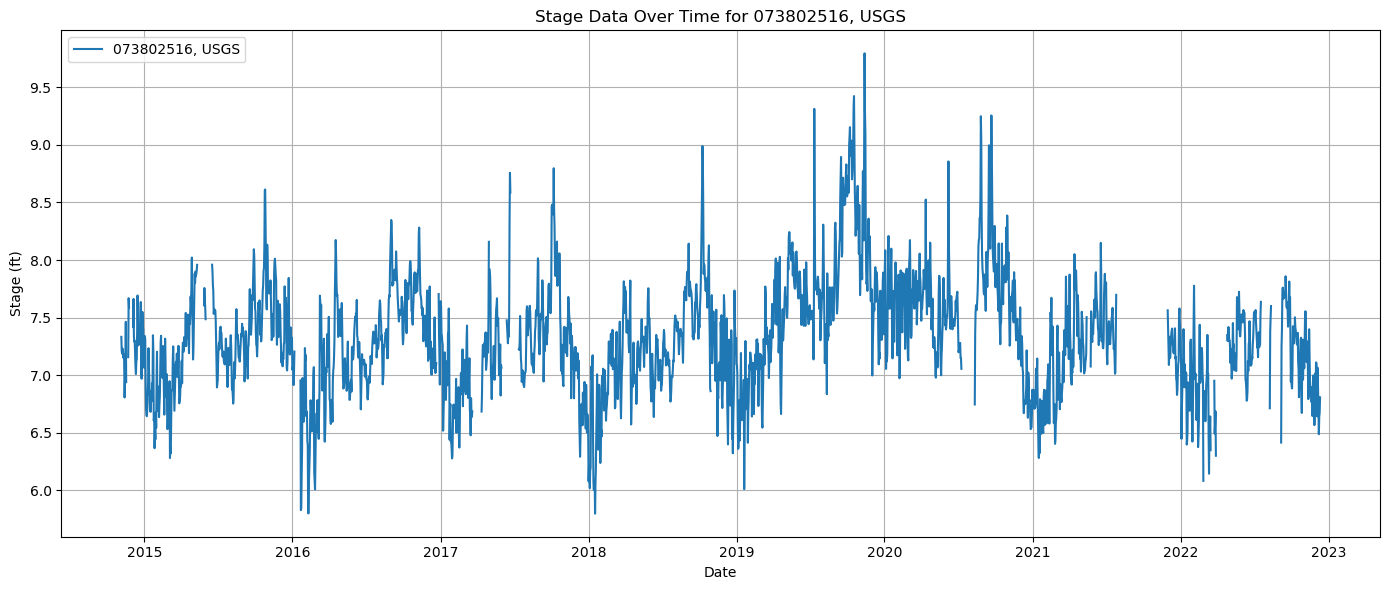

In [124]:
"""
Plots the stage data over time for a specific USGS gage site.

The script carries out the following steps:
1. Sets the figure size for the plot.
2. Plots the stage data for site against the dates from the `df_usgs_stage` DataFrame.
3. Sets the title, x-axis label, y-axis label, and legend for the plot.
4. Adds grid lines for better readability.
5. Adjusts the layout for optimal display.
6. Displays the plot.

Attributes:
    df_usgs_stage (DataFrame): DataFrame containing consolidated stage data for USGS gages.

Note:
    Ensure that the `matplotlib` library is imported, and that `df_usgs_stage` is already defined and populated before executing the script. The script assumes that the column "073802516, USGS" exists in the DataFrame.
"""
plt.figure(figsize=(14, 6))
plt.plot(df_usgs_stage.index, df_usgs_stage["073802516, USGS"], label="073802516, USGS")
plt.title('Stage Data Over Time for 073802516, USGS')
plt.xlabel('Date')
plt.ylabel('Stage (ft)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Display Column Names of the Discharge Data DataFrame

In [125]:
"""
Displays the column names of the `df_usgs_discharge` DataFrame, which contains consolidated discharge data for USGS gages.

The script prints the column names of the `df_usgs_discharge` DataFrame to provide a quick overview of the available data columns.

Attributes:
    df_usgs_discharge (DataFrame): DataFrame containing consolidated discharge data for USGS gages.
"""
print(df_usgs_discharge.columns)

Index(['07380238, USGS', '07381324, USGS', '07381235, USGS', '07381000, USGS',
       '073814675, USGS', '07380401, USGS', '295124089542100, USGS',
       '07374525, USGS', '295501090190400, USGS', '073802280, USGS',
       '07380210, USGS', '07381670, USGS', '07381590, USGS', '07381600, USGS',
       '07381454, USGS', '07385765, USGS', '07381427, USGS', '07381429, USGS',
       '07380120, USGS', '07376300, USGS', '07374000, USGS', '07378500, USGS',
       '07376000, USGS', '07378000, USGS', '07376500, USGS', '07375500, USGS',
       '07375450, USGS', '07377300, USGS', '02492000, USGS', '07375000, USGS',
       '07375960, USGS', '07381482, USGS', '073556009, USGS', '07377600, USGS',
       '07377500, USGS', '02491800, USGS', '02489500, USGS', '07377000, USGS',
       '07375800, USGS', '07375300, USGS', '07386980, USGS', '07385700, USGS',
       '07386880, USGS', '08012150, USGS', '08010050, USGS', '07386700, USGS',
       '07386190, USGS', '08012000, USGS', '08015500, USGS', '08013500,

## Visualize Discharge Data Over Time for a Specific USGS Gage

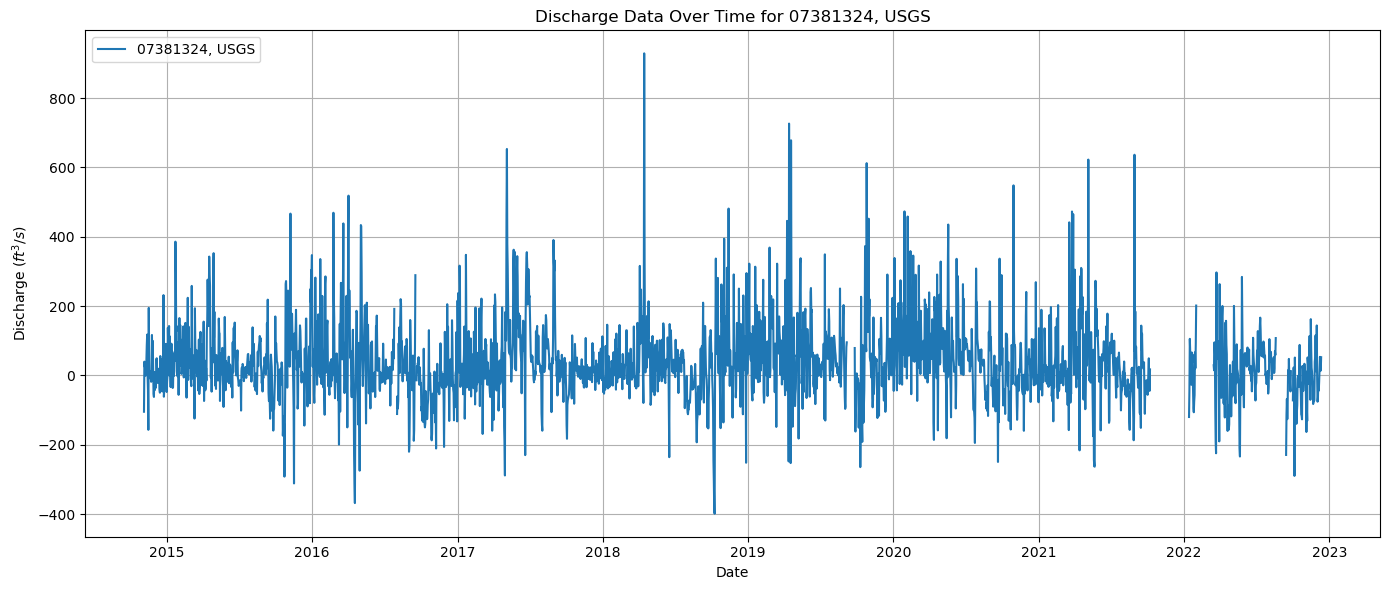

In [126]:
"""
Plots the discharge data over time for a specific USGS gage site.

The script carries out the following steps:
1. Sets the figure size for the plot.
2. Plots the discharge data for site against the dates from the `df_usgs_discharge` DataFrame.
3. Sets the title, x-axis label, y-axis label, and legend for the plot.
4. Adds grid lines for better readability.
5. Adjusts the layout for optimal display.
6. Displays the plot.

Attributes:
    df_usgs_discharge (DataFrame): DataFrame containing consolidated discharge data for USGS gages.

Note:
    Ensure that the `matplotlib` library is imported, and that `df_usgs_discharge` is already defined and populated before executing the script. The script assumes that the column "07381324, USGS" exists in the DataFrame.
"""
plt.figure(figsize=(14, 6))
plt.plot(df_usgs_discharge.index, df_usgs_discharge["07381324, USGS"], label="07381324, USGS")
plt.title('Discharge Data Over Time for 07381324, USGS')
plt.xlabel('Date')
plt.ylabel('Discharge ($ft^3/s$)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualize Stage Data Over Time for All USGS Gages

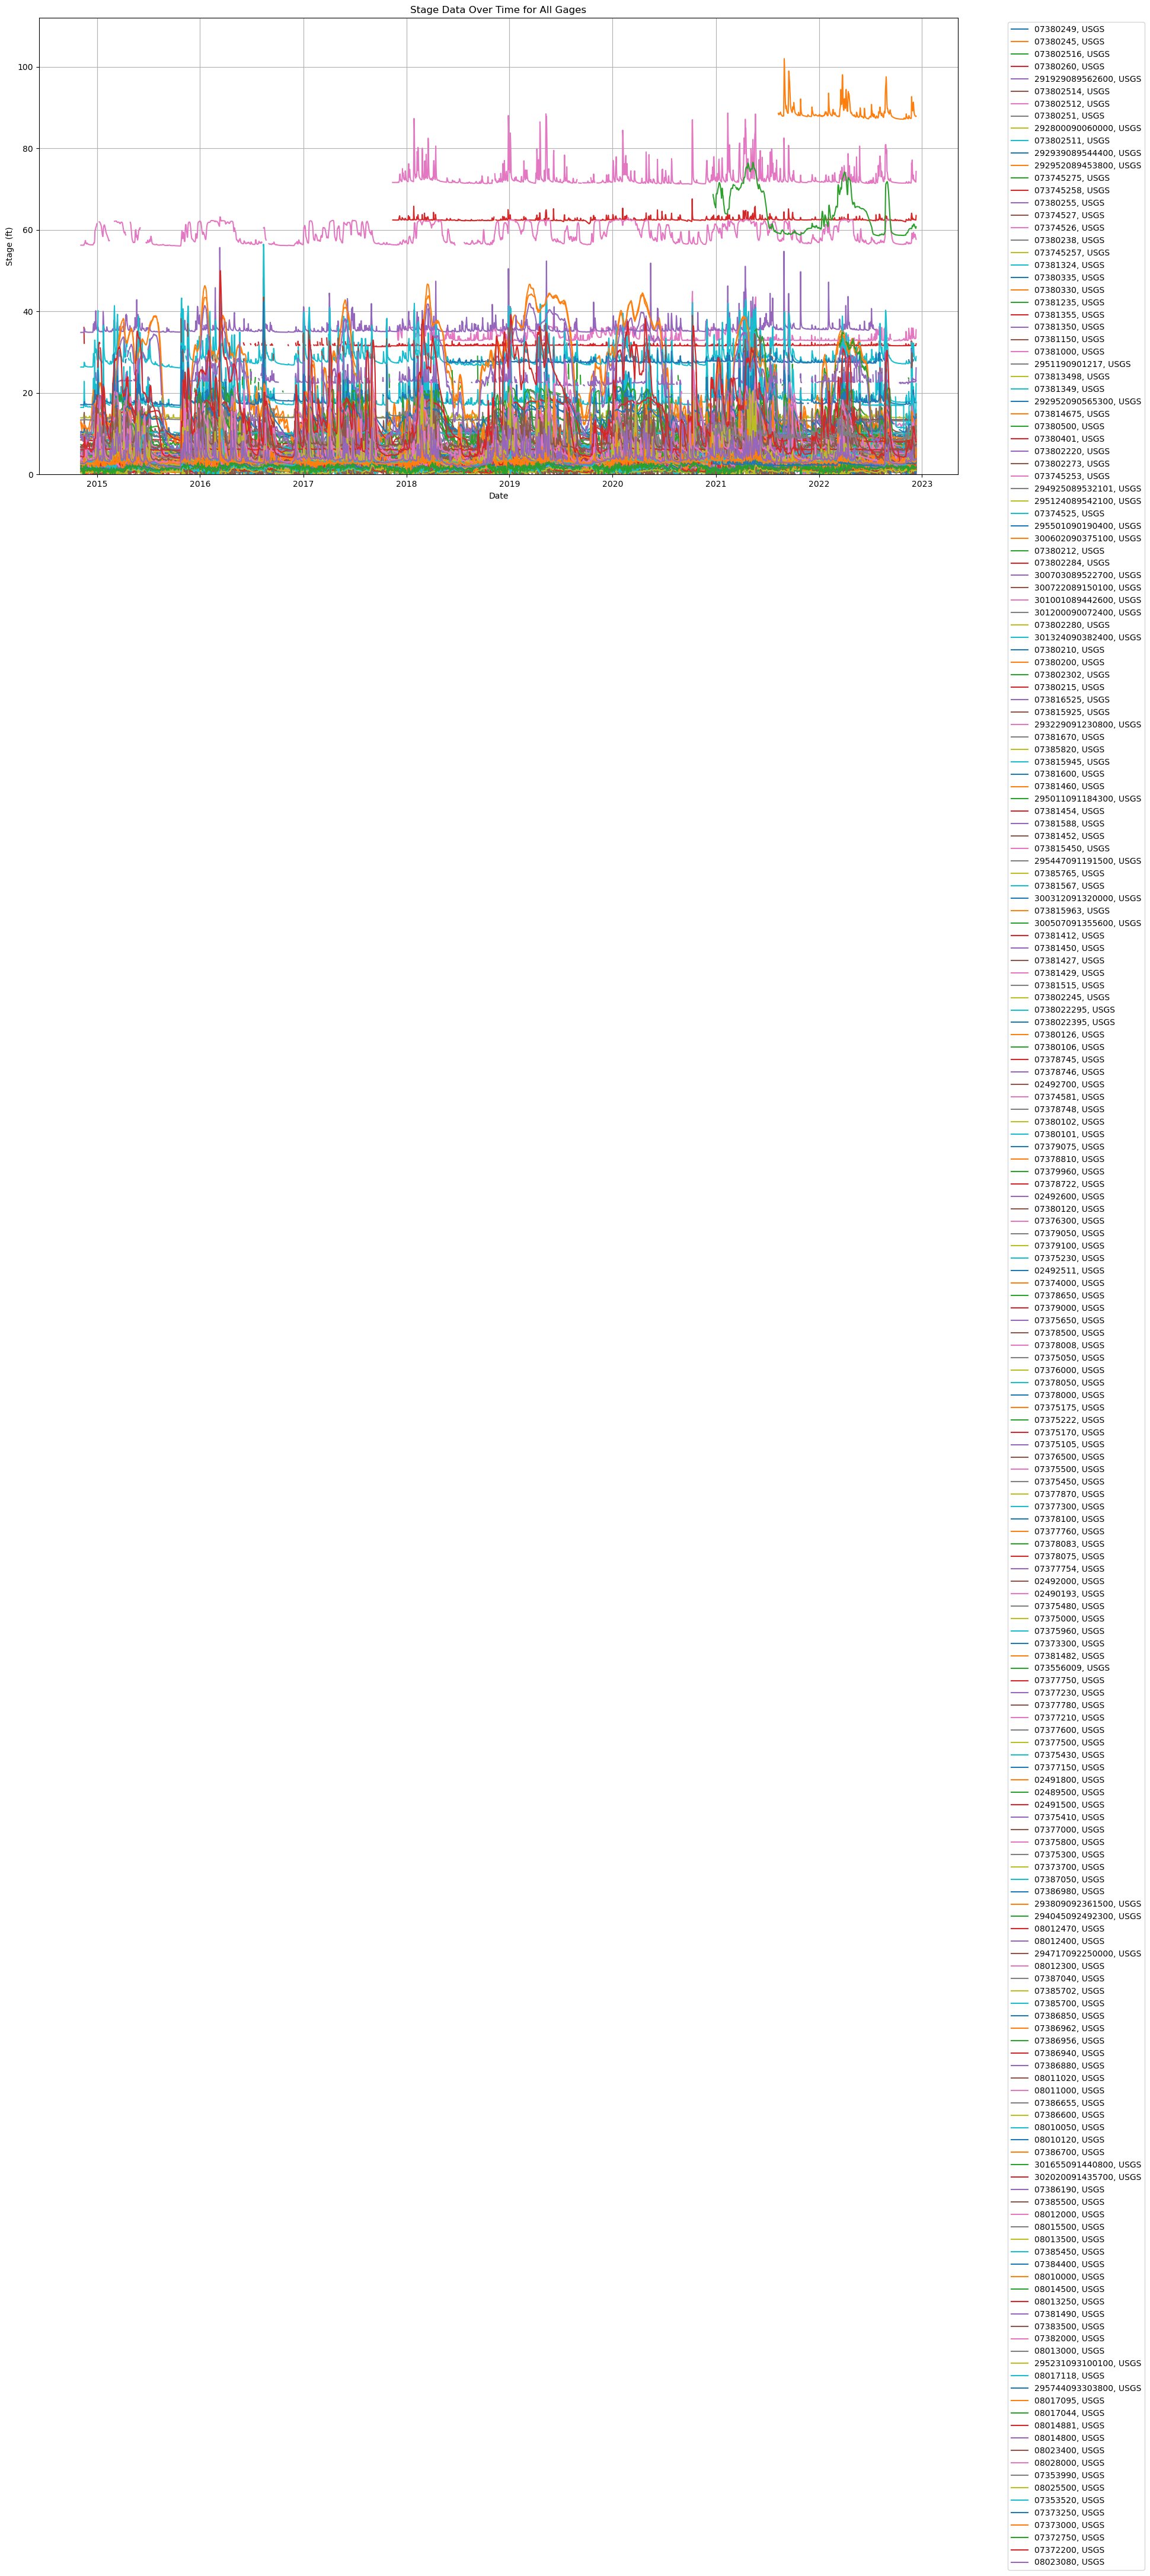

In [127]:
"""
Plots the stage data over time for all USGS gage sites present in the `df_usgs_stage` DataFrame.

The script carries out the following steps:
1. Sets the figure size for the plot.
2. Iterates over each column in the `df_usgs_stage` DataFrame, plotting the stage data for each USGS gage site against the dates.
3. Sets the title, x-axis label, y-axis label, and legend for the plot.
4. Adjusts the y-axis limits to accommodate the maximum stage value across all gages with some buffer.
5. Adds grid lines for better readability.
6. Displays the plot.

Attributes:
    df_usgs_stage (DataFrame): DataFrame containing consolidated stage data for USGS gages.

Note:
    Ensure that the `matplotlib` library is imported, and that `df_usgs_stage` is already defined and populated before executing the script.
"""
plt.figure(figsize=(20, 10))
for column in df_usgs_stage.columns:
    plt.plot(df_usgs_stage.index, df_usgs_stage[column], label=column)

plt.title('Stage Data Over Time for All Gages')
plt.xlabel('Date')
plt.ylabel('Stage (ft)')
plt.ylim(0, df_usgs_stage.max().max() + 10)  # Setting y-axis limits
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

## Visualize Discharge Data Over Time for All USGS Gages

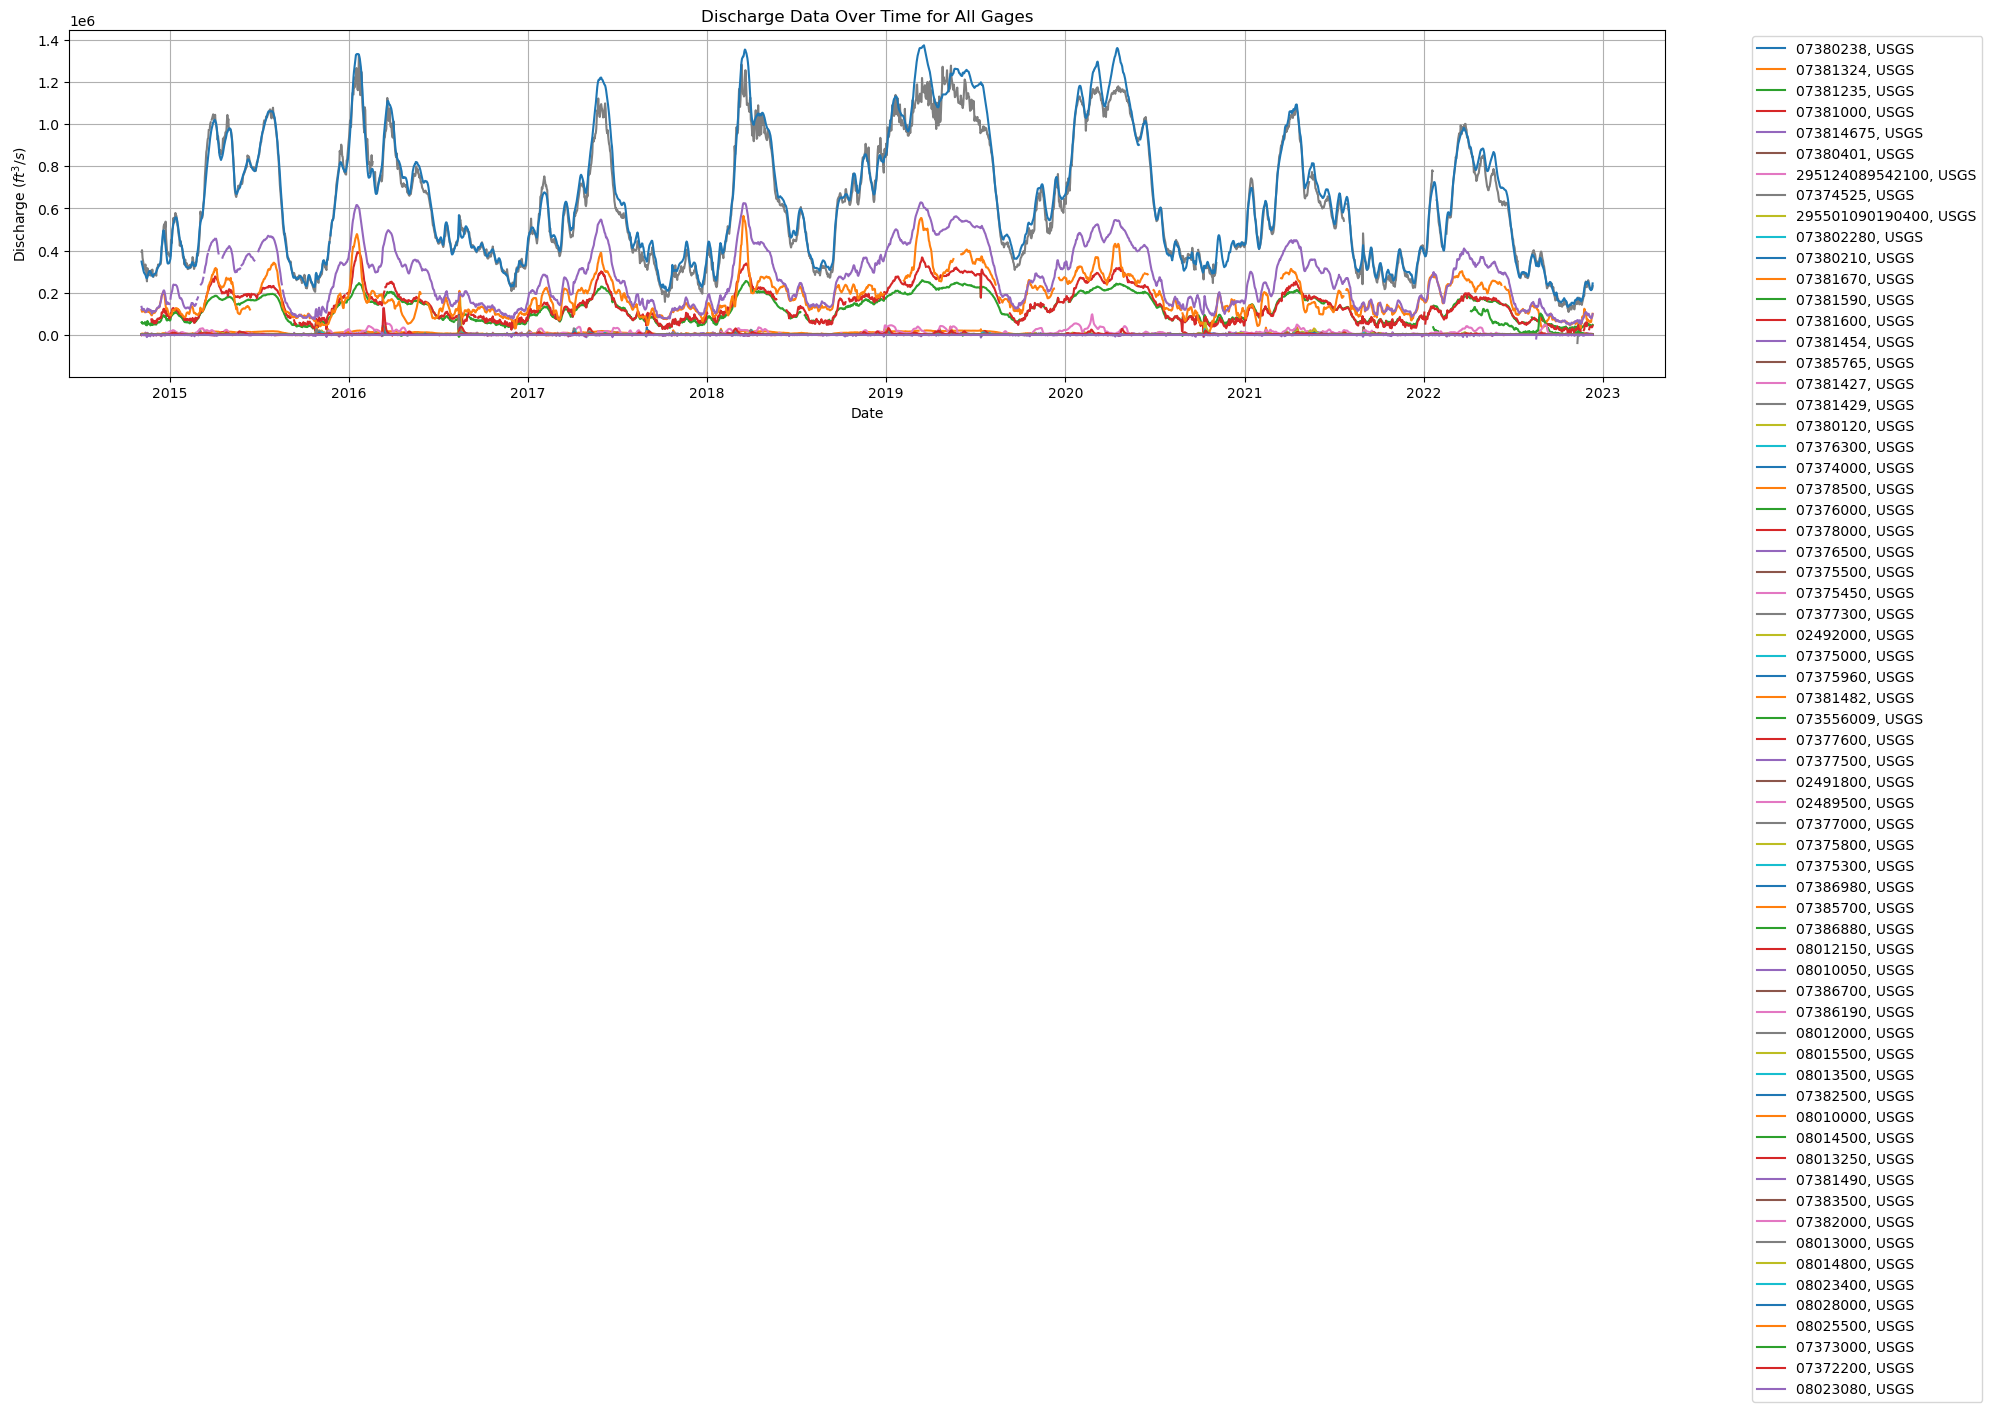

In [128]:
"""
Plots the discharge data over time for all USGS gage sites present in the `df_usgs_discharge` DataFrame.

The script carries out the following steps:
1. Sets the figure size for the plot.
2. Iterates over each column in the `df_usgs_discharge` DataFrame, plotting the discharge data for each USGS gage site against the dates.
3. Sets the title, x-axis label, y-axis label, and legend for the plot.
4. Adds grid lines for better readability.
5. Adjusts the layout for optimal display.
6. Displays the plot.

Attributes:
    df_usgs_discharge (DataFrame): DataFrame containing consolidated discharge data for USGS gages.

Note:
    Ensure that the `matplotlib` library is imported, and that `df_usgs_discharge` is already defined and populated before executing the script.
"""
plt.figure(figsize=(20, 10))
for column in df_usgs_discharge.columns:
    plt.plot(df_usgs_discharge.index, df_usgs_discharge[column], label=column)

plt.title('Discharge Data Over Time for All Gages')
plt.xlabel('Date')
plt.ylabel('Discharge ($ft^3/s$)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()